In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
%matplotlib inline

from sklearn.linear_model import Ridge, Lasso
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import warnings
warnings.filterwarnings("ignore")

In [139]:
df_house['Heating'].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [160]:
df_house = pd.read_csv('../data/train.csv', index_col=0)
df_house_test = pd.read_csv('../data/test.csv', index_col=0)
df_all = pd.concat((df_house.iloc[:, :-1], df_house_test))
y_train = np.log(df_house['SalePrice'])

# feature engineering
df_all['MSSubClass'] = df_all['MSSubClass'].replace([40, 150], 'Other')
df_all['MSZoning'] = df_all['MSZoning'].fillna('RL')
df_all['OverallQual'] = df_all['OverallQual'].map(lambda x: 2 if x < 3 else x).astype(str)
df_all['Fireplaces'] = df_all['Fireplaces'].replace(4, 3)
df_all['GarageQual'] = df_all['GarageQual'].replace({'Po':'Fa', 'Ex':'Gd'})
df_all['GarageCond'] = df_all['GarageCond'].replace({'Ex':'Gd'})
df_all['KitchenQual'] = df_all['KitchenQual'].fillna('TA')
df_all['Exterior1st'] = df_all['Exterior1st'].replace(['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc'], 'Other')
df_all['Exterior2nd'] = df_all['Exterior2nd'].replace(['Brk Cmn', 'AsphShn', 'Stone', 'CBlock'], 'Other')
df_all['BsmtHalfBath'] = df_all['BsmtHalfBath'].fillna(0).replace(2, 1)
df_all['BedroomAbvGr'] = df_all['BedroomAbvGr'].replace(8, 6).astype(str)
df_all['Functional'] = df_all['Functional'].replace('Sev', 'Maj2')
df_all['LowQualFinSF'] = np.where(df_all['LowQualFinSF'] == 0, 0, 1)
df_all['MiscFeature'] = (df_all['MiscFeature'] == 'Shed') * 1
df_all['Street'] = 1 * (df_all['Street'] == 'Pave')
df_all['HeatingQC'] = df_all['HeatingQC'].replace('Po', 'Fa')
df_all['Electrical'] = df_all['Electrical'].fillna('Other').replace(['FuseP', 'Mix'], 'Other')
df_all['KitchenAbvGr'] = (df_all['KitchenAbvGr'] >= 2) * 1

df_dummy_all = pd.get_dummies(df_all)
numeric_vars = df_all.columns[df_all.dtypes != 'object'].values
df_dummy_all[numeric_vars] = df_dummy_all[numeric_vars].fillna(0)

col_names_scale = df_dummy_all.columns[df_dummy_all.max() > 5]

df_dummy_all[col_names_scale] = np.log1p(df_dummy_all[col_names_scale])

# Don't center and scale variables for decision tree models
X_train_tree = df_dummy_all.loc[df_house.index].values
X_test_tree = df_dummy_all.loc[df_house_test.index].values

mean_cols_train = df_dummy_all.loc[:, col_names_scale].mean()
std_cols_train = df_dummy_all.loc[:, col_names_scale].std()
df_dummy_all.loc[:, col_names_scale] = (df_dummy_all.loc[:, col_names_scale] - mean_cols_train) / std_cols_train

df_train_final = df_dummy_all.loc[df_house.index]
df_test_final = df_dummy_all.loc[df_house_test.index]

X_train_final = df_train_final.values
X_test_final = df_test_final.values

In [161]:
alphas = np.logspace(-3, 1.7, 100)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train_final, y_train, cv=10, scoring='mean_squared_error'))
    test_scores.append(np.mean(test_score))

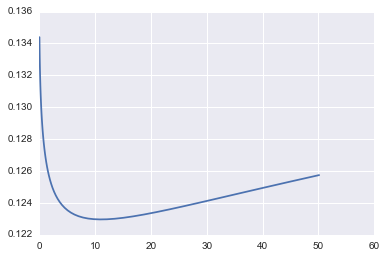

In [162]:
plt.plot(alphas, test_scores);

In [163]:
min(test_scores), alphas[np.argmin(test_scores)]

(0.12296461832043848, 10.848096388007432)

In [ ]:
# best so far .122965

In [164]:
alphas = np.linspace(.00001, .001, 20)
test_scores = []
for alpha in alphas:
    clf = Lasso(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train_final, y_train, cv=10, scoring='mean_squared_error'))
    test_scores.append(np.mean(test_score))

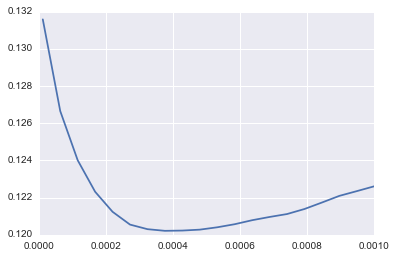

In [165]:
plt.plot(alphas, test_scores);

In [166]:
min(test_scores), alphas[np.argmin(test_scores)]

(0.12021362159882265, 0.0003747368421052632)

In [169]:
gbr = GradientBoostingRegressor(learning_rate=.03, max_depth=2, max_features=.05, n_estimators=3000)
test_score = np.sqrt(-cross_val_score(gbr, X_train_tree, y_train, cv=10, scoring='mean_squared_error'))
np.mean(test_score)

0.11615026575565737

## Drop in error: Ridge/Lasso/GBR
* Fill all na with 0: .136 / .133 / .117
* Categorize MSSubClass: .135 / .132 / .117
* Log of all numeric values: .1243 / .121 / .115
* Logged and centered and scaled: .124 / .121 / .117
* Best engineered features .1230 / .1202

In [21]:
gbr = GradientBoostingRegressor()
parameters = {'max_features':[.05, .1, .2], 'n_estimators':[2000, 3000],
             'learning_rate':[.03], 'max_depth': [2]}
clf = GridSearchCV(gbr, parameters, n_jobs=-1, scoring='mean_squared_error')
clf.fit(X_train_tree, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.03], 'max_depth': [2], 'max_features': [0.05, 0.1, 0.2], 'n_estimators': [2000, 3000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [24]:
clf.grid_scores_

[mean: -0.01529, std: 0.00279, params: {'learning_rate': 0.03, 'max_depth': 2, 'max_features': 0.05, 'n_estimators': 2000},
 mean: -0.01520, std: 0.00294, params: {'learning_rate': 0.03, 'max_depth': 2, 'max_features': 0.05, 'n_estimators': 3000},
 mean: -0.01519, std: 0.00303, params: {'learning_rate': 0.03, 'max_depth': 2, 'max_features': 0.1, 'n_estimators': 2000},
 mean: -0.01530, std: 0.00311, params: {'learning_rate': 0.03, 'max_depth': 2, 'max_features': 0.1, 'n_estimators': 3000},
 mean: -0.01538, std: 0.00346, params: {'learning_rate': 0.03, 'max_depth': 2, 'max_features': 0.2, 'n_estimators': 2000},
 mean: -0.01566, std: 0.00336, params: {'learning_rate': 0.03, 'max_depth': 2, 'max_features': 0.2, 'n_estimators': 3000}]

In [25]:
np.sqrt(-clf.grid_scores_[2].mean_validation_score)

0.12323407177323328

In [170]:
gbr = GradientBoostingRegressor(learning_rate=.03, max_depth=2, max_features=.05, n_estimators=3000)
lasso = Lasso(.0004)
ridge = Ridge(11)

gbr.fit(X_train_tree, y_train)
lasso.fit(X_train_final, y_train)
ridge.fit(X_train_final, y_train)

Ridge(alpha=11, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [171]:
y_gbr = gbr.predict(X_test_tree)
y_ridge = ridge.predict(X_test_final)
y_lasso = lasso.predict(X_test_final)
# y_svr = svr.predict(X_test_final)

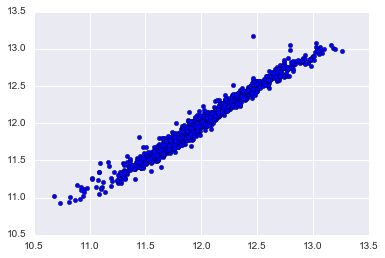

In [80]:
plt.scatter(y_gbr, y_svr)

In [172]:
y_pred = np.exp(np.mean(np.array([y_gbr, y_ridge, y_lasso]), axis=0))

In [173]:
sub_df = pd.DataFrame({'Id': df_house_test.index, 'SalePrice': y_pred})

In [174]:
sub_df.to_csv('../data/submissions/submission26.csv', index=False)

In [175]:
sub_df.head()

,Id,SalePrice
0,1461,120494.638725
1,1462,151491.309675
2,1463,189155.085510
3,1464,199896.595391
4,1465,196435.814688


In [85]:
sub_best = pd.read_csv('../data/submissions/submission13.csv', index_col=0)

In [88]:
sub_best_ens = (sub_best + sub_df.set_index('Id'))/2

In [90]:
sub_best_ens.to_csv('../data/submissions/submission26.csv')

## XGBoost

In [176]:
from xgboost.sklearn import XGBRegressor

In [177]:
xgb = XGBRegressor()

In [178]:
xgb.fit(X_train_tree, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [334]:
xgb = XGBRegressor()
parameters = {'n_estimators':[18000], 'colsample_bylevel': [.2], 'colsample_bytree': [.5], 'subsample': [.6],
             'learning_rate':[.005], 'max_depth': [3], 'reg_alpha' : [.001], 'reg_lambda':[0]}
clf = GridSearchCV(xgb, parameters, n_jobs=-1, scoring='mean_squared_error')
clf.fit(X_train_tree, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.005], 'reg_alpha': [0.001], 'n_estimators': [18000], 'subsample': [0.6], 'reg_lambda': [0.01, 0.001, 0.05, 0, 0.005], 'colsample_bylevel': [0.2], 'max_depth': [3], 'colsample_bytree': [0.5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [335]:
clf.grid_scores_

[mean: -0.01412, std: 0.00299, params: {'learning_rate': 0.005, 'reg_alpha': 0.001, 'n_estimators': 18000, 'subsample': 0.6, 'reg_lambda': 0.01, 'colsample_bylevel': 0.2, 'max_depth': 3, 'colsample_bytree': 0.5},
 mean: -0.01411, std: 0.00296, params: {'learning_rate': 0.005, 'reg_alpha': 0.001, 'colsample_bylevel': 0.2, 'subsample': 0.6, 'reg_lambda': 0.001, 'n_estimators': 18000, 'max_depth': 3, 'colsample_bytree': 0.5},
 mean: -0.01445, std: 0.00281, params: {'reg_alpha': 0.001, 'learning_rate': 0.005, 'n_estimators': 18000, 'subsample': 0.6, 'reg_lambda': 0.05, 'colsample_bylevel': 0.2, 'max_depth': 3, 'colsample_bytree': 0.5},
 mean: -0.01409, std: 0.00296, params: {'reg_alpha': 0.001, 'learning_rate': 0.005, 'n_estimators': 18000, 'subsample': 0.6, 'reg_lambda': 0, 'colsample_bylevel': 0.2, 'max_depth': 3, 'colsample_bytree': 0.5},
 mean: -0.01409, std: 0.00293, params: {'reg_alpha': 0.001, 'learning_rate': 0.005, 'n_estimators': 18000, 'subsample': 0.6, 'reg_lambda': 0.005, 'col

In [336]:
clf.best_params_

{'colsample_bylevel': 0.2,
 'colsample_bytree': 0.5,
 'learning_rate': 0.005,
 'max_depth': 3,
 'n_estimators': 18000,
 'reg_alpha': 0.001,
 'reg_lambda': 0,
 'subsample': 0.6}

In [337]:
np.sqrt(-clf.best_score_)

0.11868803896103827

In [ ]:
# best .11868

In [338]:
# xgb = XGBRegressor(colsample_bylevel=.2, colsample_bytree=.5, learning_rate=.01, max_depth=2, 
#                    n_estimators=10000,reg_alpha=.1, reg_lambda=.01, subsample=.6)
xgb = XGBRegressor(colsample_bylevel=.2, colsample_bytree=.5, learning_rate=.005, max_depth=3, 
                   n_estimators=18000, reg_alpha=.001, reg_lambda=0, subsample=.6)
lasso = Lasso(.0004)
ridge = Ridge(11)

xgb.fit(X_train_tree, y_train)
lasso.fit(X_train_final, y_train)
ridge.fit(X_train_final, y_train)

Ridge(alpha=11, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [339]:
y_xgb = xgb.predict(X_test_tree)
y_ridge = ridge.predict(X_test_final)
y_lasso = lasso.predict(X_test_final)

In [340]:
y_pred = np.exp(np.mean(np.array([y_xgb, y_lasso, y_ridge]), axis=0))

In [341]:
sub_df = pd.DataFrame({'Id': df_house_test.index, 'SalePrice': y_pred})
sub_df.to_csv('../data/submissions/submission29.csv', index=False)

In [344]:
sub_best = pd.read_csv('../data/submissions/submission13.csv', index_col=0)
sub_best_ens = (sub_best + sub_df.set_index('Id'))/2
sub_best_ens.to_csv('../data/submissions/submission30.csv')